# Notebook to extract the max of Specific heat

In [1]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


unitcell-2_p-2.0_nv-2_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\unitcell-2_p-2.0_nv-2_h-0.free-energy.h5
C_V max.: 0.45359082
Temp. at C_V max.: 0.83341475
unitcell-2_p-2.0_nv-3_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\unitcell-2_p-2.0_nv-3_h-0.free-energy.h5
C_V max.: 0.51115457
Temp. at C_V max.: 0.93429409
unitcell-2_p-2.0_nv-4_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\unitcell-2_p-2.0_nv-4_h-0.free-energy.h5
C_V max.: 0.55499854
Temp. at C_V max.: 0.99071812
unitcell-2_p-2.0_nv-5_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\unitcell-2_p-2.0_nv-5_h-0.free-energy.h5
C_V max.: 0.58870996
Temp. at C_V max.: 1.0283341
unitcell-2_p-

c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\ipykernel_launcher.py:58: Matpl


Temp. at C_V max.: 1.1001466
unitcell-2_p-2.0_nv-10_h-0.yml
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\unitcell-2_p-2.0_nv-10_h-0.free-energy.h5
C_V max.: 0.69282782
Temp. at C_V max.: 1.1086957


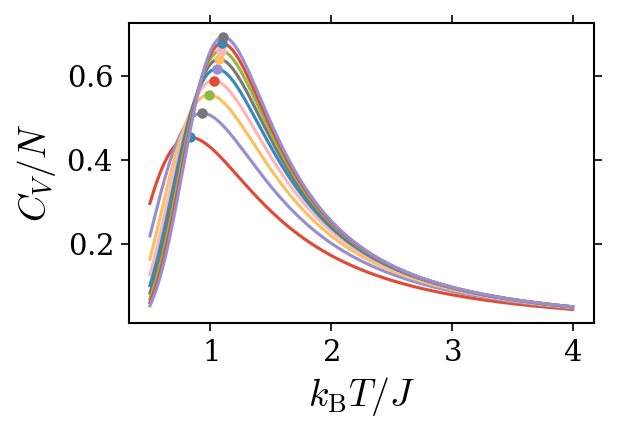

Exporting data to C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\imperfect\infinite-size\unitcell_2\ratio_1.5\p_2.0\max_cv.csv


In [3]:
list_exp_p = [2.0]
list_nv = [2,3,4,5,6,7,8,9,10]
all_max_cv = {}
for exp_p in list_exp_p:
    all_max_cv[exp_p] = {}
    data_path = Path("../../data/imperfect/infinite-size/unitcell_2/ratio_1.5/p_{}".format(exp_p)).resolve()
    all_files = os.listdir(data_path)

    use_tex = False

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = use_tex

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    for nv in list_nv:
        try:
            file = 'unitcell-2_p-{}_nv-{}_h-0.yml'.format(exp_p,nv)
            config_file = Path(os.path.join(data_path,file)).resolve()
            energy_file = config_file.with_suffix(".free-energy.h5")
            print(file)
            print(energy_file)

            with config_file.open() as cfp:
                config_info = yaml.load(cfp)
            config_data = read_ising_config(config_info)

            with h5py.File(str(energy_file)) as h5fp:
                data_energy = h5fp["/free-energy"][()]

            temp = config_data["system"]["temperature"]
            mag_field = config_data["system"]["magnetic_field"]
            free_erg = data_energy[:, :]

            # Zero magnetic field spline
            free_erg_spl_zmf = interp.UnivariateSpline(temp,
                                                       free_erg[:, 0],
                                                       s=0, k=4)
            temp_fine = np.linspace(temp.min(), temp.max(), 2048)

            # Second derivative of the free energy.
            free_erg_der_spl_zmf = free_erg_spl_zmf.derivative(n=2)
            cv_fine = -temp_fine * free_erg_der_spl_zmf(temp_fine)
            cv_max_idx = np.argmax(cv_fine)
            temp_cv_max, cv_max = temp_fine[cv_max_idx], cv_fine[cv_max_idx]

            print(f"C_V max.: {cv_max:.8G}")
            print(f"Temp. at C_V max.: {temp_cv_max:.8G}")
            all_max_cv[exp_p][nv] = {
                'max_Cv': cv_max,
                'temp_at_max_Cv': temp_cv_max
            }


            # Specific heat subplot.
            ax: Axes = fig1.add_subplot(grid_spec[0, 0])

            ax.plot(temp_fine, cv_fine, lw=1.5)
            ax.plot(temp_cv_max, cv_max, marker="o", lw=0)

            ax.set_xlabel(r"$k_\mathrm{B} T / J$")
            ax.set_ylabel(r"$C_V / N$")
            
        except KeyError:
            print('error with this file {}'.format(file))

    pyplot.draw()
    pyplot.show()

    # Export to pandas 
    print('Exporting data to {}'.format(os.path.join(data_path,'max_cv.csv')))
    df = pd.DataFrame(all_max_cv[exp_p])
    df.loc['inv_temp_at_max_Cv'] = 1/df.loc['temp_at_max_Cv']
    df = df.reindex(sorted(df.columns), axis=1)
    df.to_csv(os.path.join(data_path,'exp_p-{}_max_cv.csv'.format(exp_p)))